In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import warnings

In [2]:
ds = xr.open_dataset('../jobs/RHmid/data/RHmid.nc')

# add anomalies to datasets
for exp in ['cnt-ref','sai-ref','sai-cnt']:
    exp1,exp2 = exp.split('-')
    diff = ds.sel(exp=exp1) - ds.sel(exp=exp2)
    diff = diff.assign_coords(exp=exp)
    ds = xr.concat((ds,diff), dim='exp')

# add month weights
ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31])

# add 2D latitude and longitude for plotting
ds['lat2d'], ds['lon2d'] = xr.broadcast(ds.lat, ds.lon)
ds = ds.set_coords(['lat2d', 'lon2d'])

In [3]:
data = ds.RHmid.weighted(ds.dpm).mean('month')
print('exp','[min, 0.02 pct, 0.98 pct, max]')
for exp in data.exp.data:
    print(exp, data.sel(exp=exp).quantile([0,0.02,0.98,1]).data)

exp [min, 0.02 pct, 0.98 pct, max]
ref [ 8.88630524 15.58770419 77.66112227 90.83764588]
cnt [10.10250079 15.70834693 76.41756206 89.72201526]
sai [10.0453443  16.7415754  78.13927949 91.49616893]
cnt-ref [-11.33181804  -4.55092034   4.04882109   6.90838076]
sai-ref [-7.77715159 -4.05832133  3.73612917  5.93284359]
sai-cnt [-8.0542514  -3.65394158  4.69570843 10.56481286]


In [4]:
cfkwargs_abs = dict(levels=np.arange(0,100.1,10), vmin=0, vmax=100, extend='neither', cmap='YlGnBu', transform=ccrs.PlateCarree(), transform_first=True)
cfkwargs_rel = dict(levels=np.arange(-7,7.1,1), vmin=-7.5, vmax=7.5, extend='both', cmap='RdBu_r', transform=ccrs.PlateCarree(), transform_first=True)

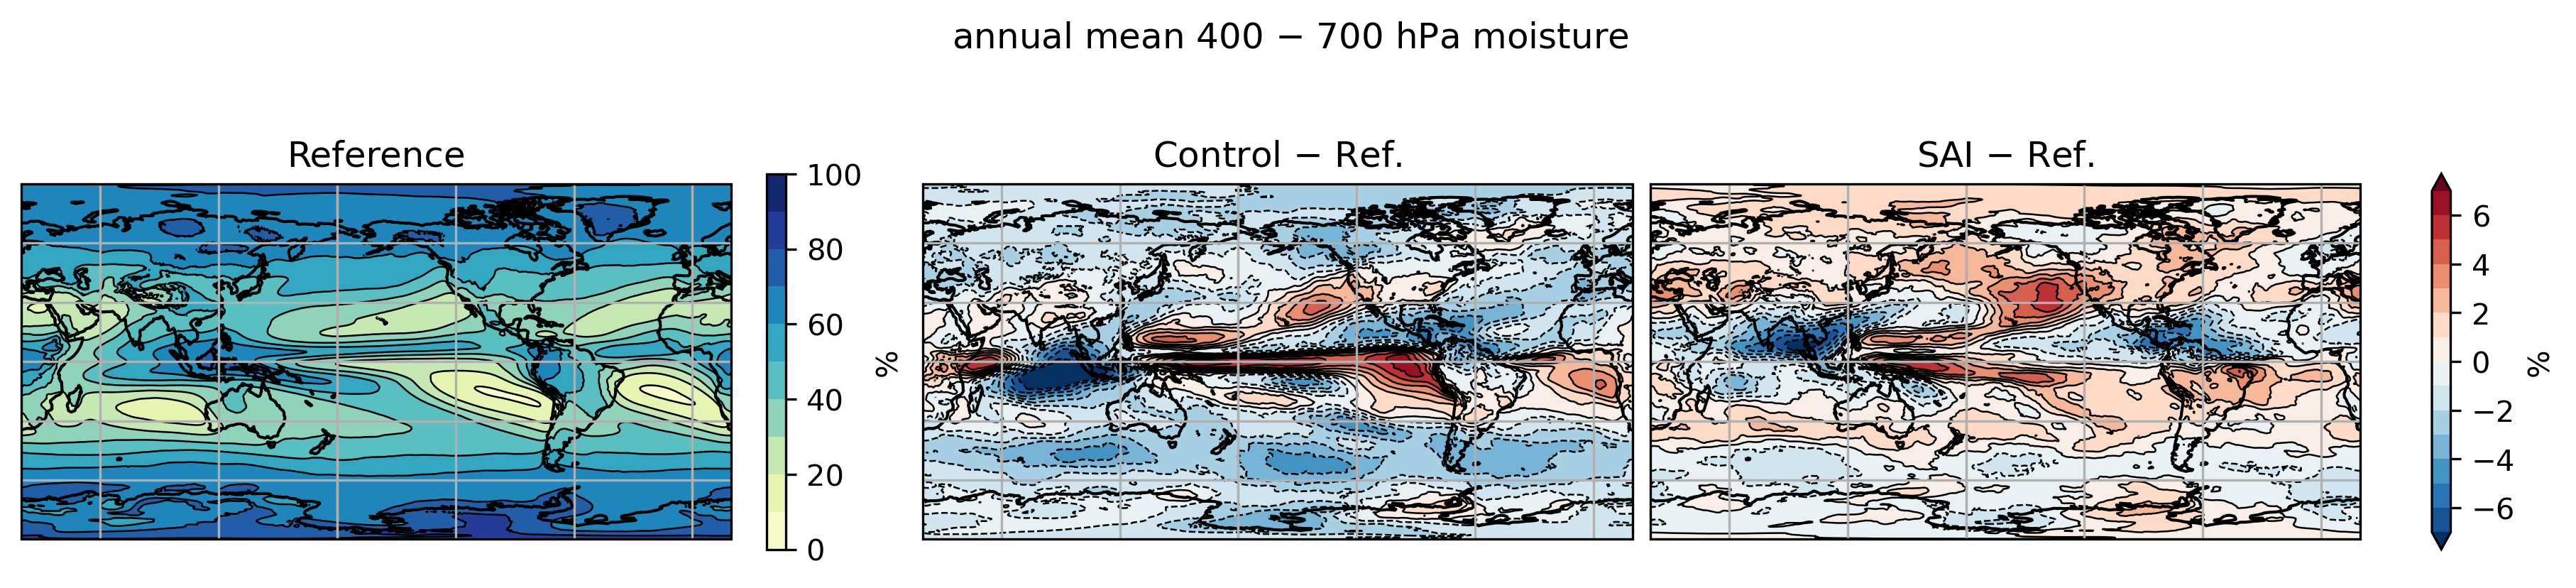

In [5]:
data = ds.RHmid.weighted(ds.dpm).mean('month')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

ax=axs[0]
pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp='ref'), **cfkwargs_abs)
psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp='ref'), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
#pcm.set_rasterized(True)
#psm.set_rasterized(True)
#ax.contour(data.lon2d, data.lat2d, data.sel(exp='ref'), levels=[25], colors='k', linewidths=1.2, linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('%')
ax.set_title('Reference')

for ax,exp,tit in zip(axs[1:],['cnt-ref','sai-ref'],['Control $-$ Ref.','SAI $-$ Ref.']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    #pcm.set_rasterized(True)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('%')

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean 400 $-$ 700 hPa moisture', y=0.9)
fig.savefig('../figures/RHmid.annualmean.pdf', bbox_inches='tight', transparent=True)

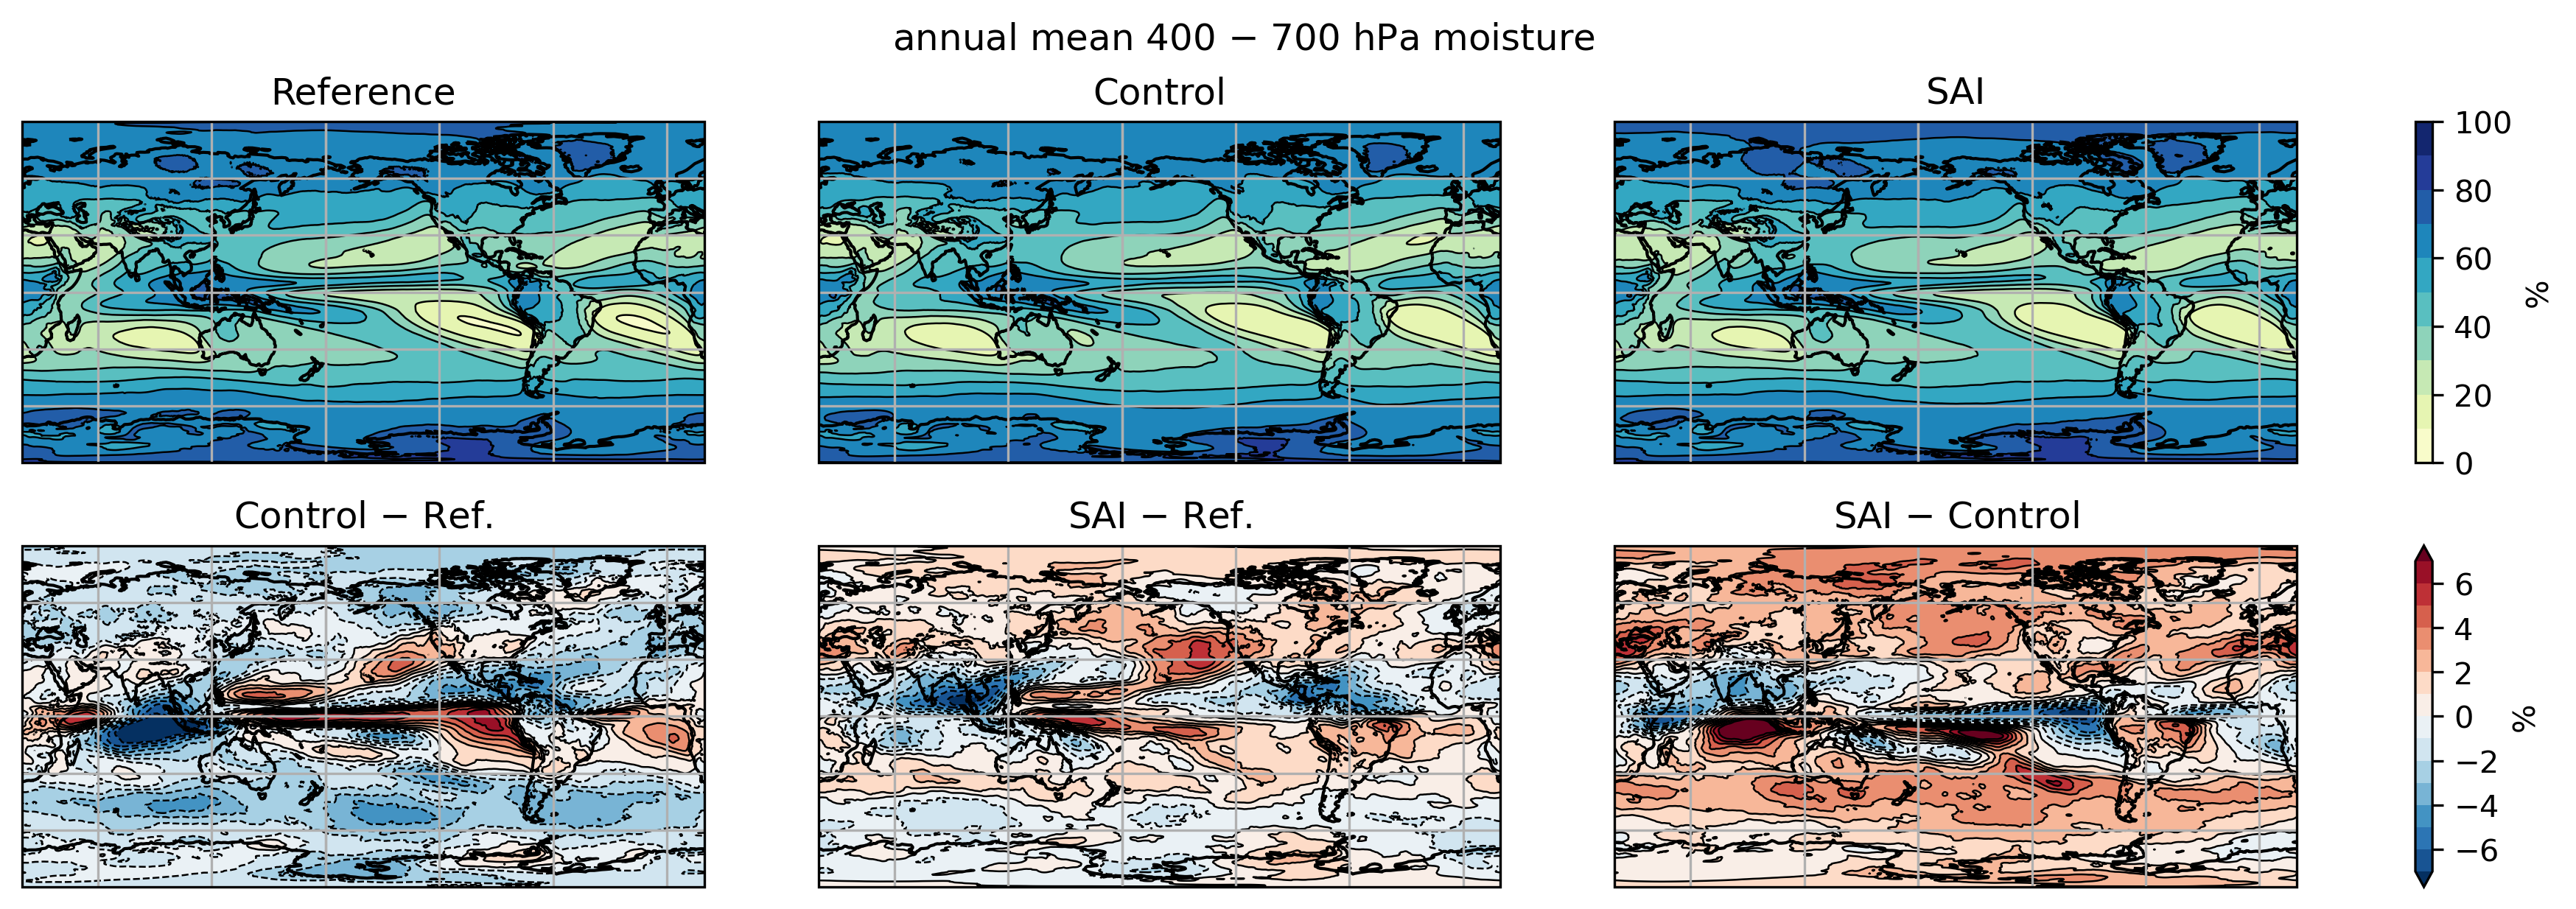

In [6]:
data = ds.RHmid.weighted(ds.dpm).mean('month')

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

fig,axs = plt.subplots(2,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

# top row: ref, cnt, sai
for ax,exp,tit in zip(axs[0,:], ['ref','cnt','sai'],['Reference','Control','SAI']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_abs)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=0.6, **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[0,:], orientation='vertical')
cb.ax.set_ylabel('%')

# bottom row: differences
for ax,exp,tit in zip(axs[1,:],['cnt-ref','sai-ref','sai-cnt'],['Control $-$ Ref.','SAI $-$ Ref.','SAI $-$ Control']):
    pcm = ax.contourf(data.lon2d, data.lat2d, data.sel(exp=exp), **cfkwargs_rel)
    psm = ax.contour(data.lon2d, data.lat2d, data.sel(exp=exp), levels=pcm.levels, colors='k', linewidths=[0.6], **kwargs)
    ax.set_title(tit)
cb = fig.colorbar(pcm, ax=axs[1,:], orientation='vertical')
cb.ax.set_ylabel('%')

for ax in axs.flatten():
    ax.gridlines()
    ax.coastlines()

fig.suptitle('annual mean 400 $-$ 700 hPa moisture')
fig.savefig('../figures/RHmid.annualmean.full.pdf', bbox_inches='tight', transparent=True)

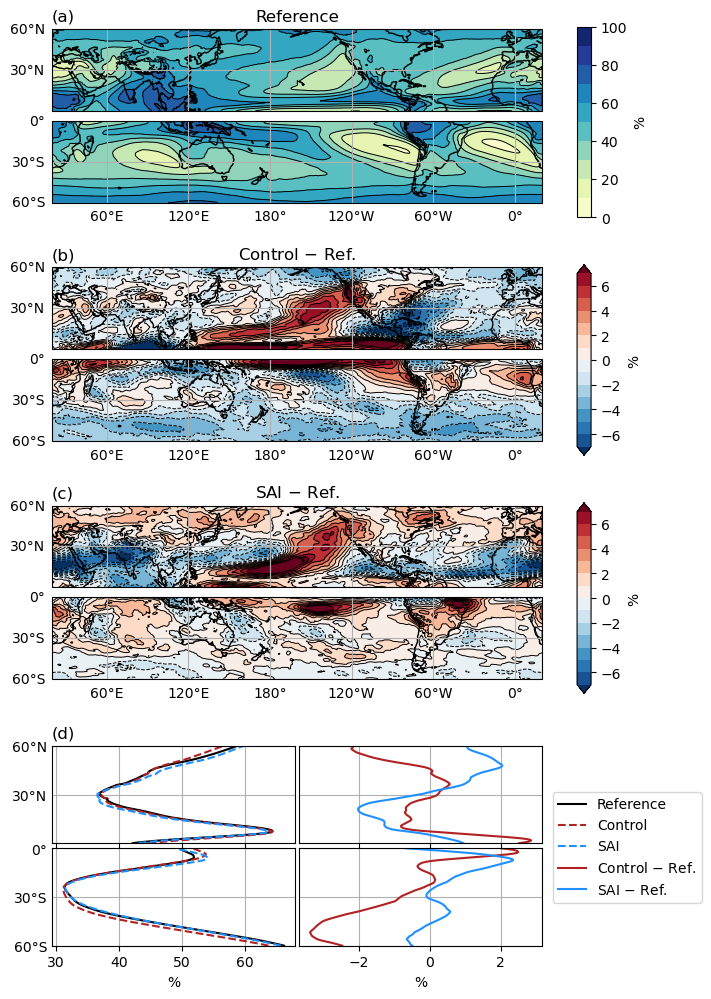

In [7]:
data_NH = ds.RHmid.sel(month=[6,7,8,9,10], lat=slice(0,60)).weighted(ds.dpm).mean('month')
data_SH = ds.RHmid.sel(month=[1,2,3,4,5], lat=slice(-60,0)).weighted(ds.dpm).mean('month')

cfdata = {
    'a': [data_NH.sel(exp='ref'), data_SH.sel(exp='ref')],
    'b': [data_NH.sel(exp='cnt-ref'), data_SH.sel(exp='cnt-ref')],
    'c': [data_NH.sel(exp='sai-ref'), data_SH.sel(exp='sai-ref')],
}

cfkwargs = {'a': cfkwargs_abs, 'b': cfkwargs_rel, 'c': cfkwargs_rel}
cbkwargs = {'a': dict(label='%'), 'b': dict(label='%'), 'c': dict(label='%')}
supy = {'a': 'Reference', 'b': 'Control $-$ Ref.', 'c': 'SAI $-$ Ref.'}

fig = plt.figure(figsize=(7, 10))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 1.2])
mapfigs = subfigs[0].subfigures(3,1,hspace=0, wspace=0)
zmfig = subfigs[1]#.subfigures(1,1,wspace=0)

for i,mfig, in zip('abc', mapfigs.flatten()):
    axt, axb = mfig.subplots(2,1, sharex=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
    cft = axt.contourf(cfdata[i][0].lon2d, cfdata[i][0].lat2d, cfdata[i][0], **cfkwargs[i])
    cfb = axb.contourf(cfdata[i][1].lon2d, cfdata[i][1].lat2d, cfdata[i][1], **cfkwargs[i])
    cst = axt.contour(cfdata[i][0].lon2d, cfdata[i][0].lat2d, cfdata[i][0], levels=cft.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    csb = axb.contour(cfdata[i][1].lon2d, cfdata[i][1].lat2d, cfdata[i][1], levels=cfb.levels, colors='k', linewidths=0.7, transform=ccrs.PlateCarree())
    for ax in (axt, axb):
        ax.coastlines()
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')
    axt.gridlines(ylocs=[0, 30, 60], draw_labels=['left'])
    axb.gridlines(ylocs=[0,-30,-60], draw_labels=['left','bottom'])
    axt.set_extent((20,380,0,60.0001), crs=ccrs.PlateCarree())
    axb.set_extent((20,380,-60.001,0.001), crs=ccrs.PlateCarree())
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.15, hspace=0.05)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    mfig.colorbar(cft, cax=cbtax, **cbkwargs[i])
    axt.set_title(f'({i})', loc='left')
    axt.set_title(supy[i])

axs = zmfig.subplots(2,2, sharey='row', sharex='col')
zmfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05/3)
for ax in axs[0,:]:
    ax.set_ylim([0,60])
    ax.yaxis.set_tick_params(length=0)
for ax in axs[1,:]:
    ax.set_ylim([-60,0])
    ax.yaxis.set_tick_params(length=0)
axs[0,0].set_yticks([30,60], labels=['30°N','60°N'])
axs[1,0].set_yticks([-60,-30,0], labels=['60°S','30°S','0°'])

zmfig.axes[0].set_title('(d)', loc='left')
data_NH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='k', label='Reference')
data_NH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='firebrick', ls='--', label='Control')
data_NH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[0], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_NH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_NH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[1], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

data_SH.sel(exp='ref').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='k', label='Reference')
data_SH.sel(exp='cnt').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='firebrick', ls='--', label='Control')
data_SH.sel(exp='sai').mean('lon').plot(ax=zmfig.axes[2], y='lat', c='dodgerblue', ls='--', label='SAI')

(data_SH.sel(exp='cnt-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='firebrick', label='Control $-$ Ref.')
(data_SH.sel(exp='sai-ref').mean('lon')).plot(ax=zmfig.axes[3], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfig.axes[0].get_legend_handles_labels()
han2, lab2 = zmfig.axes[1].get_legend_handles_labels()
zmfig.legend(han1+han2, lab1+lab2, loc=(0.84,0.35))

zmfig.axes[0].set_xlabel('')
zmfig.axes[1].set_xlabel('')
zmfig.axes[2].set_xlabel('%')
zmfig.axes[3].set_xlabel('%')

for ax in zmfig.axes:
    ax.yaxis.set_tick_params(length=0)
    ax.set_title('')
    ax.set_ylabel('')
    ax.grid()

fig.savefig('../figures/RHmid.TCseason.pdf', transparent=True, bbox_inches='tight')

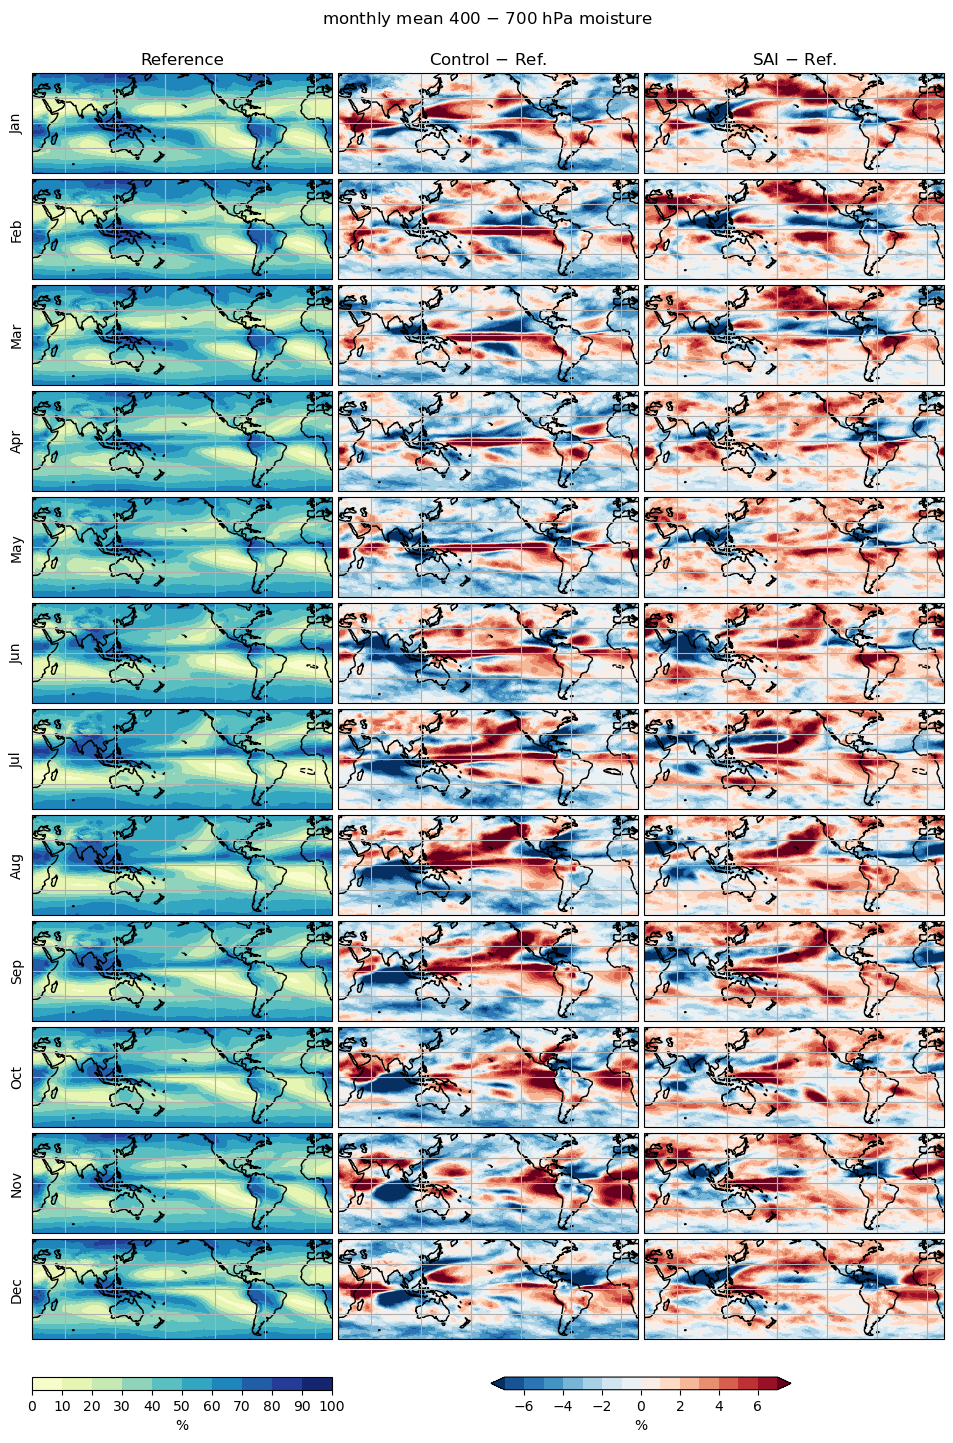

In [8]:
data = ds.RHmid.sel(lat=slice(-60,60))

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

for m,mon in enumerate(data.month):
    for i,exp in enumerate(['ref','cnt-ref','sai-ref']):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lon2d, datai.lat2d, datai, **cfkwargs_rel)
            cs = axs[m,i].contour(datai.lon2d, datai.lat2d, data.sel(exp=exp.split('-')[0], month=mon), transform=ccrs.PlateCarree(), levels=[5], colors='k', linewidths=1, linestyles='-')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
                cs.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lon2d, datai.lat2d, datai, **cfkwargs_abs)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lon2d, datai.lat2d, data.sel(exp='ref', month=mon), transform=ccrs.PlateCarree(), levels=[5], colors='k', linewidths=1, linestyles='--')      
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        cl = axs[m,i].coastlines()
        gl = axs[m,i].gridlines(ylocs=range(-60,61,30), xlocs=range(-180,181,60), crs=ccrs.PlateCarree())
        axs[m,i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

for e,exp in enumerate(['ref','cnt-ref','sai-ref']):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,101,10), orientation='horizontal', label='%')
cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,2), orientation='horizontal', label='%')
#cbr_ax.axvline(5, c='k', lw=1, ls='--')
#cbr_ax.axvline(5, c='k', lw=1)

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.05*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)

fig.suptitle('monthly mean 400 $-$ 700 hPa moisture', y=1.05)
fig.savefig('../figures/RHmid.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')

In [1]:
"""Original contents of TCs-under-SAI/analysis/src/interpolate.py"""
import os
import sys
import glob
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from numba import float32, float64, guvectorize

def pressure_from_hybrid(ds, cell_interface=False):
    """Calculate atmospheric pressure from hybrid coefficients

    ds : xr.Dataset
        dataset from which to obtain hybrid coefficients, 
        reference and surface pressure
    cell_interface : Bool
        if True, calculate pressure at vertical cell interfaces, 
        else use midpoints (default)

    returns:
    xr.DataArray : 3D atmospheric pressure, same units as ds.PS
    """

    if cell_interface:
        P = ds.hyai * ds.P0 + ds.hybi * ds.PS
    else:
        P = ds.hyam * ds.P0 + ds.hybm * ds.PS
    P = P.assign_attrs(ds.PS.attrs)
    P.attrs.update({'long_name':'Pressure'})
    
    return P


@guvectorize(
    "(float64[:], float64[:], float64[:], float32[:])",
    " (n), (n), (m) -> (m)",
    nopython=True, target='parallel'
)
def interp1d_gu(f, x, xi, out):
    """Interpolate one-dimensional field f(x) to xi in ln(x) coordinates."""
    i, imax, x0, f0 = 0, len(xi), x[0], f[0]
    while (xi[i] < x0) and (i < imax):
        out[i] = np.nan      
        i = i + 1 
    for x1,f1 in zip(x[1:], f[1:]):
        while (xi[i] <= x1) and (i < imax):
            out[i] = (f1-f0)/np.log(x1/x0)*np.log(xi[i]/x0)+f0
            i = i + 1
        x0, f0 = x1, f1
    while i < imax:
        out[i] = np.nan
        i = i + 1


def interpolate(da, p, pi, dim, chunks={}):
    """Apply 1D interpolation function on xarray objects

    input:
    da : xr.DataArray
        field to interpolate
    p : xr.DataArray
        pressure
    pi : ArrayLike
        new pressure levels (1D)
    dim : Str
        dimension used for interpolation
    chunks : dict
        passed to da.chunk. if empty, existing chunks are retained

    returns:
    xr.DataArray
        da interpolated to new pressure levels
        dim is replaced by 'plev'
    """
    pi = xr.DataArray(name='plev', data=sorted(pi), dims='plev')
    dims = list(da.dims)
    dims[dims.index(dim)] = pi.dims[0]
    da = da.chunk(chunks)
    p = p.chunk(chunks)
    
    interped = xr.apply_ufunc(
        interp1d_gu, da, p, pi,
        input_core_dims=[[dim],[dim],pi.dims],
        output_core_dims=[pi.dims],
        exclude_dims=set((dim,)),
        dask='parallelized',
        on_missing_core_dim='drop'
    ).transpose(*dims).assign_coords({pi.name:pi}).assign_attrs(da.attrs)
    interped.name = da.name

    return interped

In [2]:
ds = xr.open_dataset("/projects/0/nwo2021025/archive/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001"
                    +"/atm/hist/hres_b.e10.B2000_CAM5.f02_t12.started_2002-12_without_SAI.001.cam2.h0.2003-01.nc")
ds.Q

<xarray.DataArray 'Q' (time: 1, lev: 30, lat: 768, lon: 1152)> Size: 106MB
[26542080 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 240B 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * time     (time) object 8B 2003-02-01 00:00:00
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
Attributes:
    mdims:         1
    units:         kg/kg
    long_name:     Specific humidity
    cell_methods:  time: mean

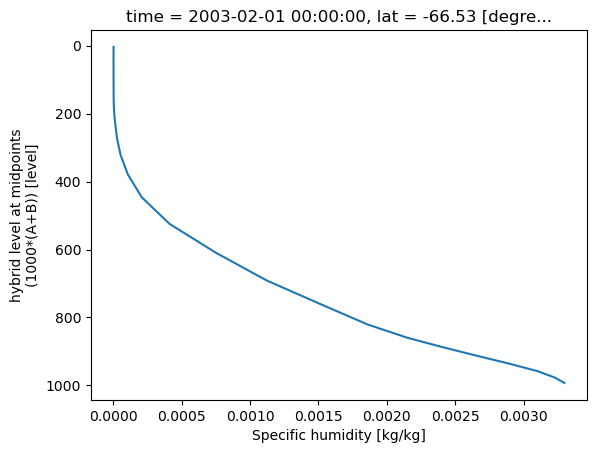

In [5]:
ds_col = ds.isel(time=0, lat=100, lon=0)
ds_col.Q.plot(y='lev',yincrease=False, yscale='linear')

We now wish to integrate Q from Pmin = 400 hPa to Pmax = 700 hPa.  
Testing a function on one column of data: 

In [6]:
def integrate(f, pi, p_min, p_max):
    """ Vertically integrate field f from p_min to p_max in pressure coordinates.
    """
    integral = 0.0
    nlev = len(f)
    for k in range(nlev):
        p_bnd = pi[k], pi[k+1]
        dp = min(p_bnd[1],p_max) - max(p_bnd[0],p_min)
        if dp <= 0:
            continue
        integral += f[k] * dp
    return integral

ds_col = ds.isel(time=0, lat=100, lon=0)
P = pressure_from_hybrid(ds_col, cell_interface=False)
Pi = pressure_from_hybrid(ds_col, cell_interface=True)
Q = ds_col.Q

print(f"{integrate(xr.ones_like(Q), Pi, 40000, 70000) = :.1f} (should be 30000)")
print(f"{integrate(xr.ones_like(Q)*2, Pi, 40000, 70000) = :.1f} (should be 60000)")
print(f"{integrate(Q, Pi, Pi.min(), Pi.max())/9.81 = :.1f} (should be {ds_col.TMQ:.1f})")

integrate(xr.ones_like(Q), Pi, 40000, 70000) = 30000.0 (should be 30000)
integrate(xr.ones_like(Q)*2, Pi, 40000, 70000) = 60000.0 (should be 60000)
integrate(Q, Pi, Pi.min(), Pi.max())/9.81 = 8.3 (should be 8.3)


In [7]:
"""new content"""

@guvectorize(
    "(float32[:], float64[:], float64, float64, float64[:])",
    " (n), (m), (), () -> ()",
    nopython=True, target='parallel'
)
def integrate1d_gu(f, pi, p_min, p_max, out):
    """Vertically integrate field f from p_min to p_max in pressure coordinates."""
    out[0] = 0.0
    nlev = len(f)
    for k in range(nlev):
        p_bnd = pi[k], pi[k+1]
        dp = min(p_bnd[1],p_max) - max(p_bnd[0],p_min)
        if dp <= 0:
            continue
        out[0] += f[k] * dp

pi = pressure_from_hybrid(ds, cell_interface=True)
out1 = xr.apply_ufunc(integrate1d_gu, xr.ones_like(ds.Q)*2, pi, 40000.0, 70000.0,
               input_core_dims=[['lev'],['ilev'],[],[]],
               output_core_dims=[[]],
               dask='parallelized',
               on_missing_core_dim='drop')
out2 = xr.apply_ufunc(integrate1d_gu, ds.Q, pi, pi.min(), pi.max(),
               input_core_dims=[['lev'],['ilev'],[],[]],
               output_core_dims=[[]],
               dask='parallelized',
               on_missing_core_dim='drop')

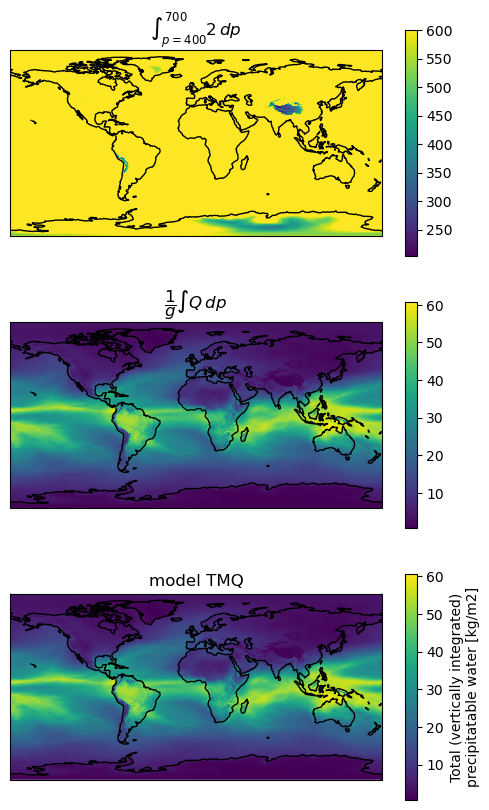

In [8]:
fig,axs = plt.subplots(3,1,figsize=(6,10),subplot_kw={'projection':ccrs.PlateCarree()})

(out1/100).plot(ax=axs[0],transform=ccrs.PlateCarree())
(out2/9.8).plot(ax=axs[1],transform=ccrs.PlateCarree())
ds.TMQ.plot(ax=axs[2],transform=ccrs.PlateCarree())
axs[0].set_title(r"$\int_{p=400}^{700}2\,dp$")
axs[1].set_title(r"$\dfrac{1}{g}\int Q\,dp$")
axs[2].set_title('model TMQ')
for ax in axs:
    ax.coastlines()

Text(0.5, 1.0, '($\\dfrac{1}{g}\\int Q\\,dp$ - model TMQ) / model TMQ')

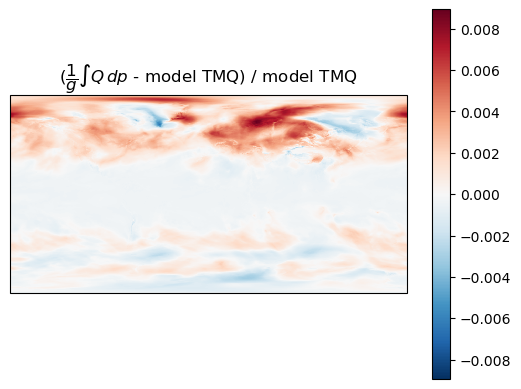

In [13]:
ax = plt.axes(projection=ccrs.PlateCarree())
(((out2/9.81)-ds.TMQ)/ds.TMQ).plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_title(r"($\dfrac{1}{g}\int Q\,dp$ - model TMQ) / model TMQ")

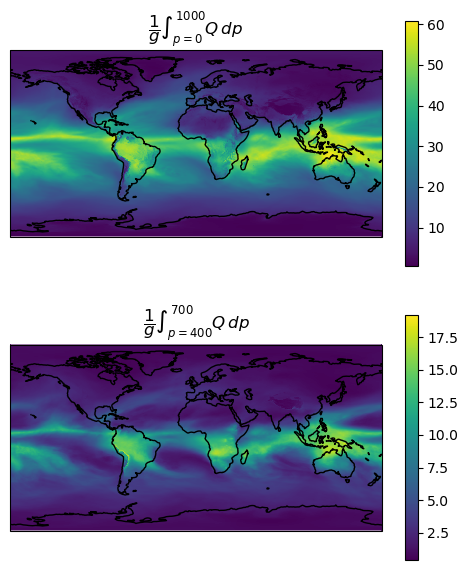

In [20]:
# added to script, let's test it again
import interpolate

pi = interpolate.pressure_from_hybrid(ds, cell_interface=True)
TMQ = interpolate.integrate(ds.Q, pi, pi.min(), pi.max()) / 9.81
Qmid = interpolate.integrate(ds.Q, pi, 40000, 70000) / 9.81

fig,axs = plt.subplots(2,1,figsize=(6,7),subplot_kw={'projection':ccrs.PlateCarree()})
TMQ.plot(ax=axs[0],transform=ccrs.PlateCarree())
Qmid.plot(ax=axs[1],transform=ccrs.PlateCarree())
axs[0].set_title(r"$\dfrac{1}{g}\int_{p=0}^{1000} Q\,dp$")
axs[1].set_title(r"$\dfrac{1}{g}\int_{p=400}^{700} Q\,dp$")
for ax in axs:
    ax.coastlines()